# Exploring Dandiset 000617: Allen Institute Openscope - Sequence Learning Project

## Important Note
This notebook was AI-generated and has not been fully verified. Please be cautious when interpreting the code or results presented here. Always validate findings with your own analysis.

## Overview

This notebook explores Dandiset 000617 (version 0.250312.0130), which contains two-photon calcium imaging data from the Allen Institute Openscope - Sequence Learning Project. The project investigates how neurons in different layers of visual cortex areas respond to sequences of natural movie clips.

Link to the Dandiset: [https://dandiarchive.org/dandiset/000617/0.250312.0130](https://dandiarchive.org/dandiset/000617/0.250312.0130)

### Experimental Design

In this experiment, head-fixed mice passively viewed sequences of three different natural movie clips (labeled 'A', 'B', 'C'), each having a duration of 2 seconds, along with a 2-second gray screen (labeled 'X'). The experimental protocol involved:

1. An initial recording session (day #0) with movie clips presented in random order
2. Three training sessions where the movie clips were presented in a repeating temporal sequence (ABCABC...)
3. A final session (day #4) with stimuli again presented in random order

The experiment used 2-photon microscopy with eight simultaneously recorded fields-of-view from both layer 2/3 and layer 4 of multiple cortical areas: V1 (VISp), LM (VISl), AM (VISam), and PM (VISpm).

### This Notebook Will Cover

In this notebook, we will:
1. Load and explore a NWB file from the Dandiset
2. Examine the structure of the data
3. Visualize calcium imaging data from neurons
4. Analyze responses to different visual stimuli
5. Explore the spatial organization of neurons

## Required Packages

The following packages are required to run this notebook:
- pynwb: for working with NWB files
- h5py: for handling HDF5 files
- remfile: for streaming remote files
- numpy: for numerical operations
- pandas: for data manipulation
- matplotlib: for data visualization
- seaborn: for enhanced visualizations

In [1]:
import pynwb
import h5py
import remfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
from IPython.display import display

# Set up plot styling
sns.set_theme()

## Loading the Dandiset

First, let's connect to the DANDI archive and retrieve information about the Dandiset.

In [2]:
from itertools import islice
from dandi.dandiapi import DandiAPIClient

# Connect to DANDI archive
client = DandiAPIClient()
dandiset = client.get_dandiset("000617", "0.250312.0130")

# Print basic information about the Dandiset
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")

# List some assets in the Dandiset
assets = dandiset.get_assets()
print("\nFirst 5 assets:")
for asset in islice(assets, 5):
    print(f"- {asset.path} (ID: {asset.identifier})")

Dandiset name: Allen Institute Openscope - Sequence Learning Project
Dandiset URL: https://dandiarchive.org/dandiset/000617/0.250312.0130

First 5 assets:
- sub-684475/sub-684475_ses-1294084428-acq-1294179945-raw-movies_ophys.nwb (ID: 3eaf1acf-7a63-4286-a7c0-7a58d8cae2f8)
- sub-684475/sub-684475_ses-1294084428-acq-1294179943-raw-movies_ophys.nwb (ID: 4cfa15bb-eac7-4273-9141-6d0cc2034506)
- sub-684475/sub-684475_ses-1293785946-acq-1293914859-raw-movies_ophys.nwb (ID: d0b9a557-2c98-4fbc-af96-2318e6e5f2eb)
- sub-684475/sub-684475_ses-1294084428-acq-1294179942-raw-movies_ophys.nwb (ID: 6b8f9ba6-2481-4c7b-b78c-38c2b878d246)
- sub-684475/sub-684475_ses-1294259213-acq-1294370666-raw-movies_ophys.nwb (ID: c407d5e4-9431-4f94-b5d0-2b28069fa244)


## Loading an NWB File

Now, let's load a specific NWB file from the Dandiset. We'll work with a file from the subject 677038 that contains processed calcium imaging data. This file is smaller and easier to work with compared to the raw data files.

In [3]:
# Define the URL for the NWB file we want to load
nwb_file_url = "https://api.dandiarchive.org/api/assets/27dd7936-b3e7-45af-aca0-dc98b5954d19/download/"
print(f"Loading NWB file from URL: {nwb_file_url}")

# Open the file
remote_file = remfile.File(nwb_file_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

# Print some basic metadata from the NWB file
print(f"\nNWB file identifier: {nwb.identifier}")
print(f"Session description: {nwb.session_description}")
print(f"Session start time: {nwb.session_start_time}")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Subject species: {nwb.subject.species}")
print(f"Subject genotype: {nwb.subject.genotype}")
print(f"Subject sex: {nwb.subject.sex}")
print(f"Subject age: {nwb.subject.age}")

# Extract experiment metadata
ophys_metadata = nwb.lab_meta_data["metadata"]
print(f"\nImaging depth: {ophys_metadata.imaging_depth} microns")
print(f"Field of view: {ophys_metadata.field_of_view_width} x {ophys_metadata.field_of_view_height} pixels")
print(f"Imaging plane group: {ophys_metadata.imaging_plane_group} of {ophys_metadata.imaging_plane_group_count}")

Loading NWB file from URL: https://api.dandiarchive.org/api/assets/27dd7936-b3e7-45af-aca0-dc98b5954d19/download/



NWB file identifier: 1280384858
Session description: Ophys Session
Session start time: 2023-06-30 16:04:51.055000+00:00
Subject ID: 677038
Subject species: Mus musculus
Subject genotype: Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt
Subject sex: F
Subject age: P92.0D

Imaging depth: 175 microns
Field of view: 512 x 512 pixels
Imaging plane group: 0 of 4


## Neuroimaging Data Structure

The NWB file contains calcium imaging data from multiple neurons. Let's examine the structure of this data.

In [4]:
# Print information about the primary imaging plane
imaging_plane = nwb.imaging_planes["imaging_plane_1"]
print(f"Imaging plane description: {imaging_plane.description}")
print(f"Imaging rate: {imaging_plane.imaging_rate} Hz")
print(f"Indicator: {imaging_plane.indicator}")
print(f"Excitation wavelength: {imaging_plane.excitation_lambda} nm")
print(f"Brain region: {imaging_plane.location}")

# Get information about cell ROIs
ophys_module = nwb.processing["ophys"]
image_seg = ophys_module.data_interfaces["image_segmentation"]
plane_seg = image_seg.plane_segmentations["cell_specimen_table"]

# Convert to DataFrame for easier viewing
cell_data = plane_seg.to_dataframe()
print(f"\nNumber of tracked cells: {len(cell_data)}")

# Display the first few rows of cell data
print("\nSample of cell data:")
display(cell_data[['cell_specimen_id', 'x', 'y', 'width', 'height', 'valid_roi']].head())

Imaging plane description: (512, 512) field of view in VISp at depth 175 um
Imaging rate: 10.0 Hz
Indicator: GCaMP6f
Excitation wavelength: 910.0 nm
Brain region: VISp



Number of tracked cells: 121

Sample of cell data:


,cell_specimen_id,x,y,width,height,valid_roi
id,,,,,,
1285902696,-1,47,47,23,22,True
1285902717,-1,282,32,18,18,True
1285902742,-1,420,35,21,19,True
1285902805,-1,348,196,23,22,True
1285902819,-1,447,197,19,20,True


## Stimulus Types

Let's examine the stimuli used in the experiment.

In [5]:
# Get information about the different stimulus types
stim_gray = nwb.intervals["gray_presentations"]
stim_A = nwb.intervals["movie_clip_A_presentations"] 
stim_B = nwb.intervals["movie_clip_B_presentations"]
stim_C = nwb.intervals["movie_clip_C_presentations"]

# Count the presentations of each stimulus type
print(f"Gray screen presentations: {len(stim_gray.to_dataframe())}")
print(f"Movie A presentations: {len(stim_A.to_dataframe())}")
print(f"Movie B presentations: {len(stim_B.to_dataframe())}")
print(f"Movie C presentations: {len(stim_C.to_dataframe())}")

# Show example of the stimulus presentation data
print("\nExample of stimulus presentation data (Gray):")
display(stim_gray.to_dataframe().head())

# Let's look at the stimulus templates
print("\nAvailable stimulus templates:")
for key in nwb.stimulus_template.keys():
    template = nwb.stimulus_template[key]
    print(f"- {key}: Shape {template.data.shape}, Frame rate {template.rate} Hz")

Gray screen presentations: 63000


Movie A presentations: 63000


Movie B presentations: 63000


Movie C presentations: 63000

Example of stimulus presentation data (Gray):


,start_time,stop_time,stimulus_name,stimulus_block,frame,color,contrast,opacity,orientation,size,units,stimulus_index,tags,timeseries
id,,,,,,,,,,,,,,
0,34.918040,34.934720,gray,6.0,0.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,3.0,[stimulus_time_interval],"[(723, 1, timestamps pynwb.base.TimeSeries at ..."
1,34.934720,34.951401,gray,6.0,1.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,3.0,[stimulus_time_interval],"[(724, 1, timestamps pynwb.base.TimeSeries at ..."
2,34.951401,34.968082,gray,6.0,2.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,3.0,[stimulus_time_interval],"[(725, 1, timestamps pynwb.base.TimeSeries at ..."
3,34.968082,34.984762,gray,6.0,3.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,3.0,[stimulus_time_interval],"[(726, 1, timestamps pynwb.base.TimeSeries at ..."
4,34.984762,35.001443,gray,6.0,4.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,3.0,[stimulus_time_interval],"[(727, 1, timestamps pynwb.base.TimeSeries at ..."



Available stimulus templates:
- gray: Shape (1280, 720, 120), Frame rate 60.0 Hz
- movie_clip_A: Shape (1280, 720, 120), Frame rate 60.0 Hz
- movie_clip_B: Shape (1280, 720, 120), Frame rate 60.0 Hz
- movie_clip_C: Shape (1280, 720, 120), Frame rate 60.0 Hz


## Calcium Imaging Data

Now let's look at the calcium imaging data (ΔF/F) from the recorded neurons.

Total recording duration: 4204.45 seconds
Sampling rate: 9.52 Hz
Number of timepoints: 40019
Number of cells: 121


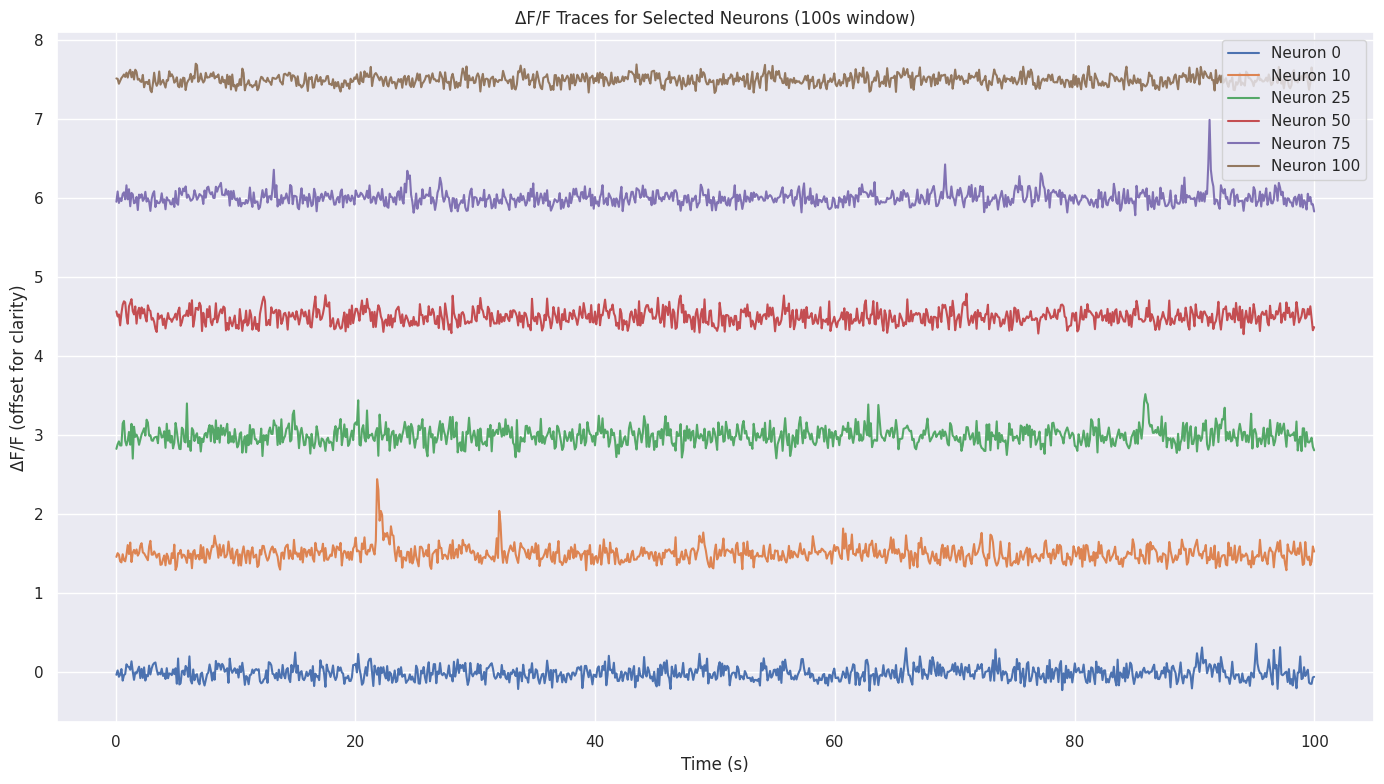

In [6]:
# Get the ΔF/F data
dff = ophys_module.data_interfaces["dff"]
dff_traces = dff.roi_response_series["traces"]

# Get basic information about the dF/F data
timestamps = dff_traces.timestamps[:]
num_timepoints = len(timestamps)
num_cells = dff_traces.data.shape[1]

print(f"Total recording duration: {timestamps[-1] - timestamps[0]:.2f} seconds")
print(f"Sampling rate: {1/np.mean(np.diff(timestamps)):.2f} Hz")
print(f"Number of timepoints: {num_timepoints}")
print(f"Number of cells: {num_cells}")

# Plot ΔF/F traces for a few neurons
plt.figure(figsize=(14, 8))

# Select a subset of neurons to display
neuron_ids = [0, 10, 25, 50, 75, 100]  # Select a few neuron indices
num_to_plot = min(len(neuron_ids), 6)  # Plot at most 6 neurons

# Create a time window for better visualization
start_time = 1000  # seconds
duration = 100  # seconds
end_time = start_time + duration

# Find the corresponding time indices
time_mask = (timestamps >= start_time) & (timestamps < end_time)
plot_times = timestamps[time_mask] - start_time  # Shifted to start at 0

for i, neuron_id in enumerate(neuron_ids[:num_to_plot]):
    # Get data for this neuron in the selected time window
    trace = dff_traces.data[time_mask, neuron_id]
    
    # Add offset for clarity in the plot
    plt.plot(plot_times, trace + i*1.5, label=f"Neuron {neuron_id}")

plt.xlabel('Time (s)')
plt.ylabel('ΔF/F (offset for clarity)')
plt.title(f'ΔF/F Traces for Selected Neurons ({duration}s window)')
plt.legend()
plt.tight_layout()

## Visualizing Neuron Responses to Stimuli

Let's visualize how neurons respond to the different movie stimuli.

Computing mean responses to stimuli...



Cells preferring each stimulus type:
  Gray: 1 cells
  Movie A: 20 cells
  Movie B: 4 cells
  Movie C: 5 cells


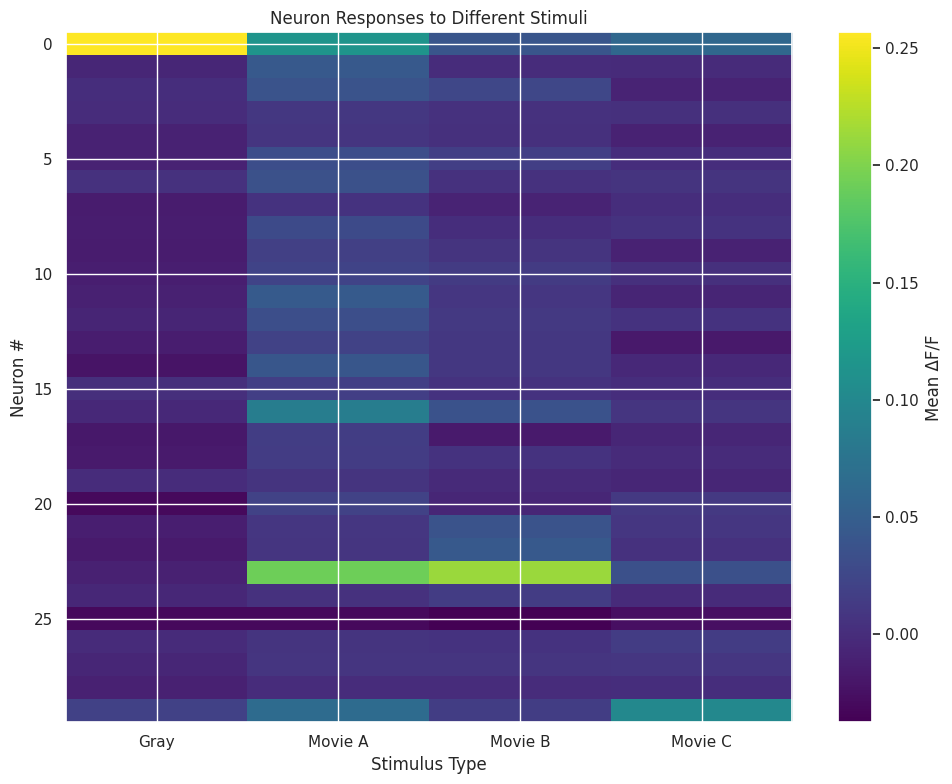

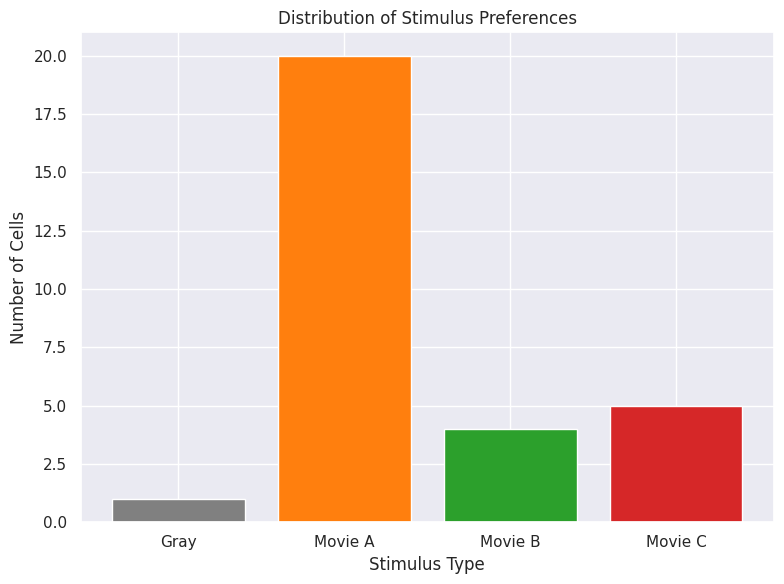

In [7]:
# Helper function to find time indices within a range
def get_indices_in_range(timestamps, start_time, end_time):
    return np.where((timestamps >= start_time) & (timestamps < end_time))[0]

# Create a function to compute average responses to stimulus presentations
def compute_mean_response(dff_data, timestamps, stim_df, n_cells, max_presentations=50):
    """Compute the mean response for each cell during stimulus presentations"""
    # Use a subset of presentations to keep computation manageable
    stim_df = stim_df.iloc[:max_presentations]  
    
    # Initialize the mean response array
    mean_responses = np.zeros((len(stim_df), n_cells))
    
    for i, (_, row) in enumerate(stim_df.iterrows()):
        start, end = row['start_time'], row['stop_time']
        time_indices = get_indices_in_range(timestamps, start, end)
        
        if len(time_indices) > 0:
            # Mean dF/F during this presentation
            mean_responses[i] = np.mean(dff_data[time_indices, :n_cells], axis=0)
    
    return mean_responses

# Number of cells to analyze (for efficiency)
n_cells_to_analyze = min(30, num_cells)

# Compute mean responses for each stimulus type (limit to 50 presentations)
print("Computing mean responses to stimuli...")
gray_responses = compute_mean_response(dff_traces.data, timestamps, 
                                      stim_gray.to_dataframe(), 
                                      n_cells_to_analyze, max_presentations=50)

A_responses = compute_mean_response(dff_traces.data, timestamps, 
                                   stim_A.to_dataframe(), 
                                   n_cells_to_analyze, max_presentations=50)

B_responses = compute_mean_response(dff_traces.data, timestamps, 
                                   stim_B.to_dataframe(), 
                                   n_cells_to_analyze, max_presentations=50)

C_responses = compute_mean_response(dff_traces.data, timestamps, 
                                   stim_C.to_dataframe(), 
                                   n_cells_to_analyze, max_presentations=50)

# Calculate overall mean for each stimulus type across presentations
gray_mean = np.mean(gray_responses, axis=0)
A_mean = np.mean(A_responses, axis=0)
B_mean = np.mean(B_responses, axis=0)
C_mean = np.mean(C_responses, axis=0)

# Find neurons with strongest preference for each movie type
movie_preferences = np.zeros(n_cells_to_analyze, dtype=int)  # 0=gray, 1=A, 2=B, 3=C
stimulus_names = ['Gray', 'Movie A', 'Movie B', 'Movie C']

for i in range(n_cells_to_analyze):
    responses = [gray_mean[i], A_mean[i], B_mean[i], C_mean[i]]
    movie_preferences[i] = np.argmax(responses)

# Count cells preferring each stimulus
preference_counts = [np.sum(movie_preferences == i) for i in range(4)]
print("\nCells preferring each stimulus type:")
for i, count in enumerate(preference_counts):
    print(f"  {stimulus_names[i]}: {count} cells")

# Plot a heatmap of neuron responses to each stimulus type
plt.figure(figsize=(10, 8))
response_matrix = np.column_stack([gray_mean, A_mean, B_mean, C_mean])

# Sort neurons by their preferred stimulus
sort_indices = np.lexsort((np.arange(n_cells_to_analyze), movie_preferences))
sorted_response_matrix = response_matrix[sort_indices, :]

# Create a heatmap
plt.imshow(sorted_response_matrix, aspect='auto', cmap='viridis')
plt.colorbar(label='Mean ΔF/F')
plt.xlabel('Stimulus Type')
plt.ylabel('Neuron #')
plt.title('Neuron Responses to Different Stimuli')
plt.xticks(np.arange(4), stimulus_names)
plt.tight_layout()

# Create bar plot of preference distribution
plt.figure(figsize=(8, 6))
plt.bar(stimulus_names, preference_counts, color=['gray', 'tab:orange', 'tab:green', 'tab:red'])
plt.xlabel('Stimulus Type')
plt.ylabel('Number of Cells')
plt.title('Distribution of Stimulus Preferences')
plt.tight_layout()

## Visualizing Neural Activity as a Heatmap

Let's create a heatmap to visualize the activity patterns of multiple neurons over time.

Text(0.5, 1.0, 'Neural Activity Heatmap')

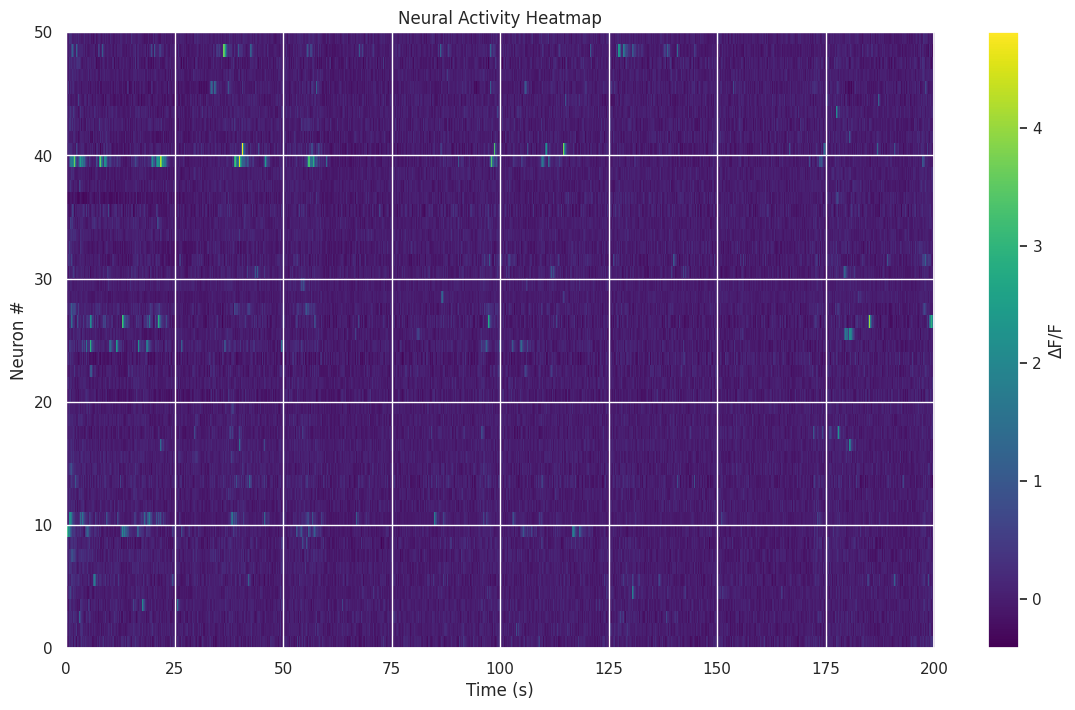

In [8]:
# Create a heatmap showing activity of multiple neurons
plt.figure(figsize=(14, 8))

# Select time window and neurons for visualization
time_window = 200  # seconds - limit plot to first 200 seconds
time_indices = timestamps < timestamps[0] + time_window
n_neurons = min(50, num_cells)  # Display up to 50 neurons

# Get the data for the heatmap
activity_data = dff_traces.data[time_indices, :n_neurons].T

# Create the heatmap
plt.imshow(
    activity_data,
    aspect='auto',
    interpolation='none',
    extent=[0, time_window, 0, n_neurons],
    cmap='viridis'
)

plt.colorbar(label='ΔF/F')
plt.ylabel('Neuron #')
plt.xlabel('Time (s)')
plt.title('Neural Activity Heatmap')

## Spatial Organization of Neurons

Let's visualize the spatial organization of the neurons in the imaging plane.

/tmp/ipykernel_89131/3725288589.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  preference_cmap = plt.cm.get_cmap('viridis', 4)


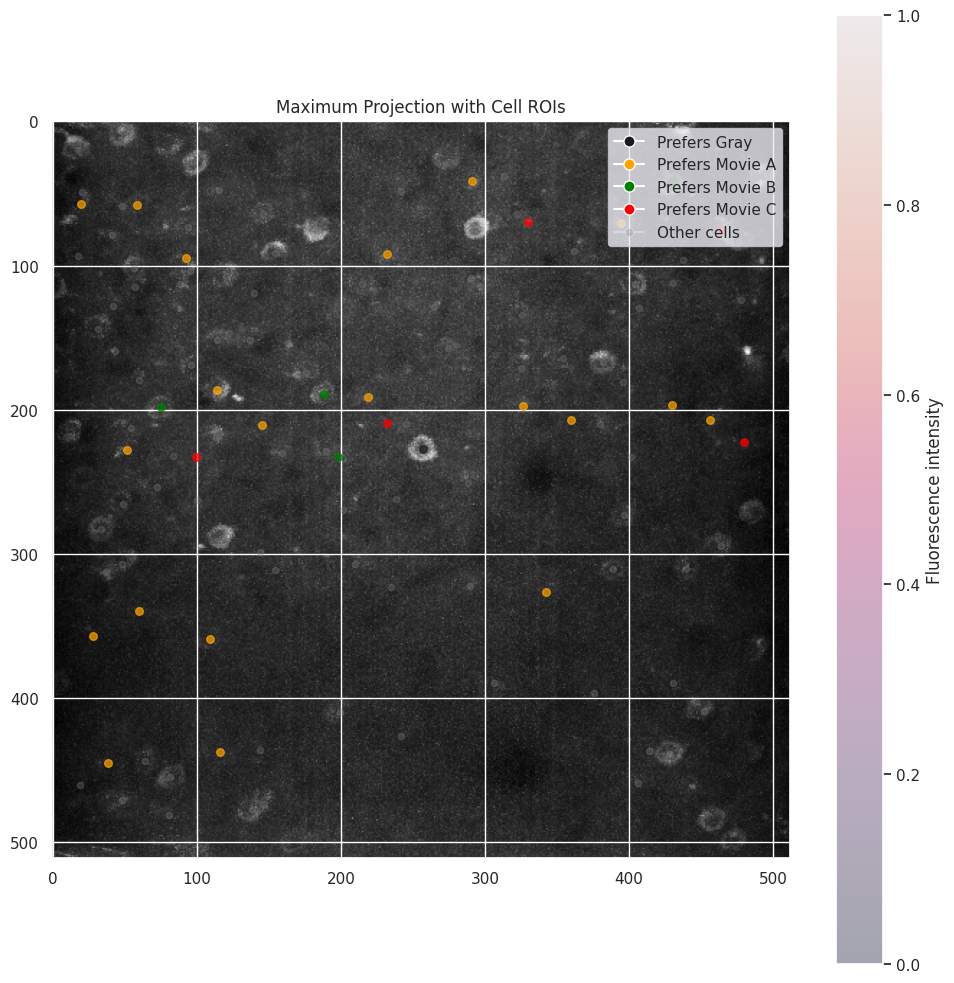

In [9]:
# Get the maximum projection image for reference
images = ophys_module.data_interfaces['images']
max_proj = np.array(images.images['max_projection'])

# Get spatial coordinates for all cells
x_pos = cell_data['x'].values
y_pos = cell_data['y'].values
width = cell_data['width'].values
height = cell_data['height'].values

# Visualize the max projection image with cell ROIs
plt.figure(figsize=(10, 10))
plt.imshow(max_proj, cmap='gray')
plt.title("Maximum Projection with Cell ROIs")

# Create a colormap based on stimulus preference (for cells we analyzed)
cell_colors = ['k', 'orange', 'green', 'red']  # Colors for Gray, A, B, C
preference_cmap = plt.cm.get_cmap('viridis', 4)

# Plot all cells with either small markers or rectangles
for i in range(len(cell_data)):
    if i < n_cells_to_analyze:
        # Color by stimulus preference for analyzed cells
        pref_idx = movie_preferences[i]
        color = cell_colors[pref_idx]
        plt.scatter(x_pos[i] + width[i]/2, y_pos[i] + height[i]/2, 
                   s=30, c=color, alpha=0.7)
    else:
        # Gray dots for other cells
        plt.scatter(x_pos[i] + width[i]/2, y_pos[i] + height[i]/2, 
                   s=20, c='gray', alpha=0.3)

# Add a legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', 
                         label=f'Prefers {stim}',
                         markerfacecolor=c, markersize=8)
                  for stim, c in zip(stimulus_names, cell_colors)]
legend_elements.append(Line2D([0], [0], marker='o', color='w', 
                             label='Other cells',
                             markerfacecolor='gray', markersize=6, alpha=0.3))
plt.legend(handles=legend_elements, loc='upper right')

plt.colorbar(label='Fluorescence intensity')
plt.tight_layout()

## Exploring Event Detection

The dataset also includes event detection data, which identifies spiking events from the calcium traces. Let's look at how these events relate to the ΔF/F traces.

Event detection data shape: (40019, 121)
Lambda values range: 0.013300000000000001 to 0.2788
Noise std values range: 0.043716952632762776 to 0.2003527550771344


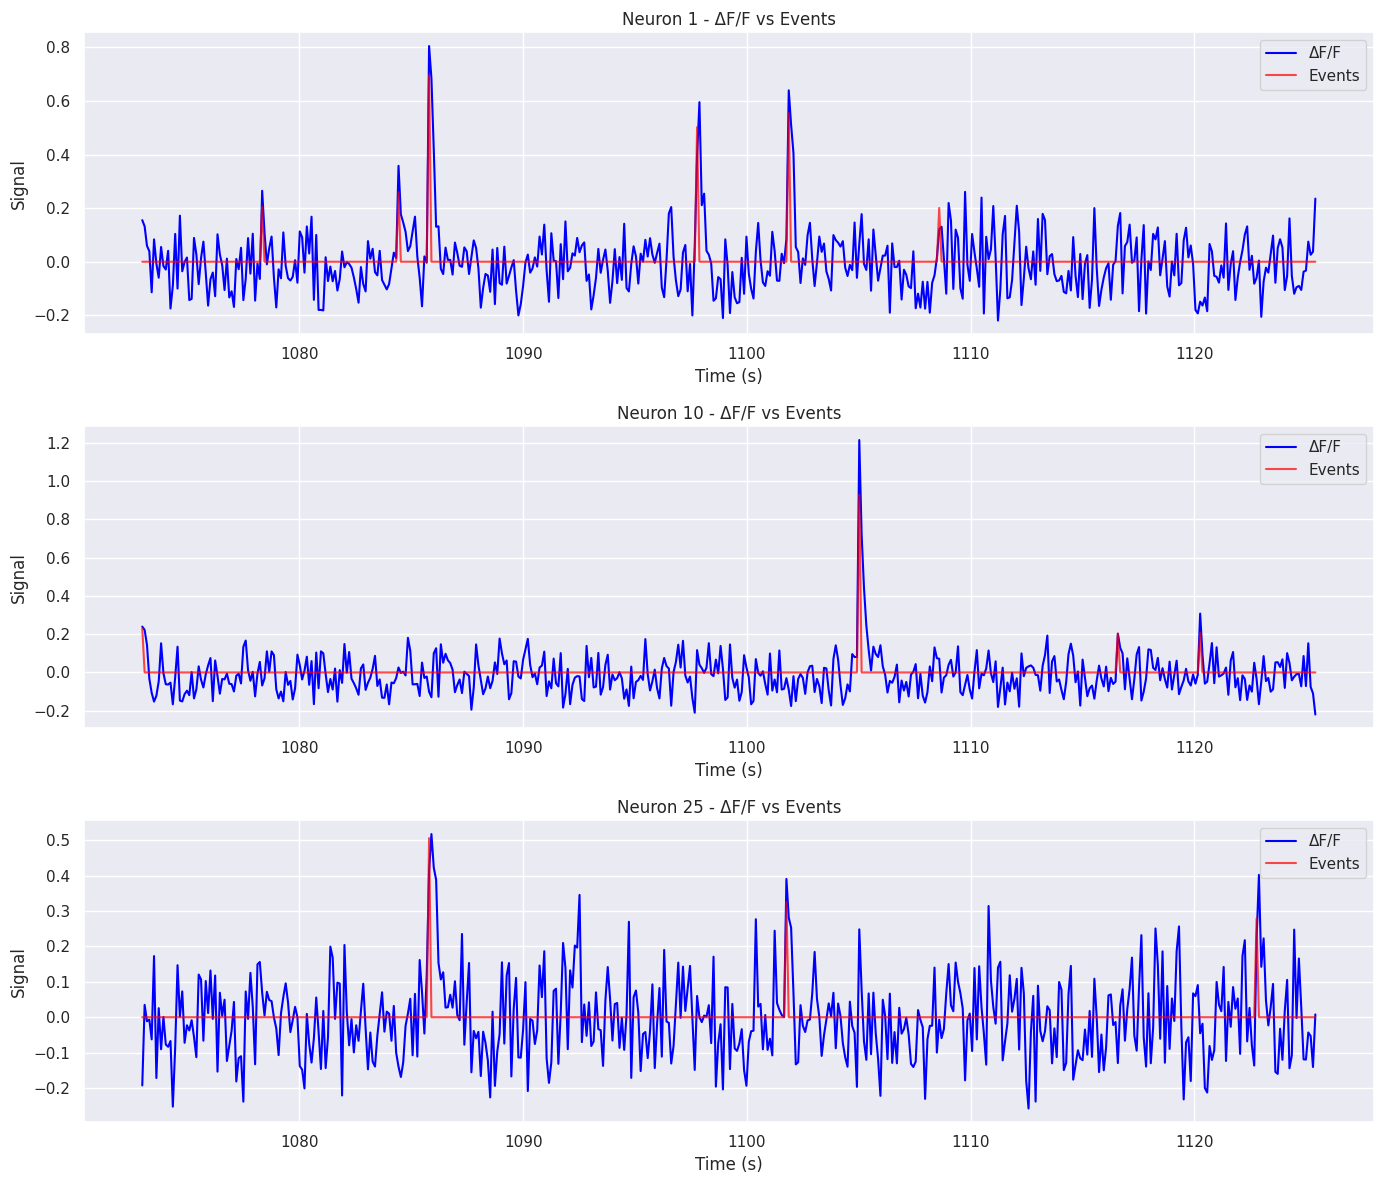

In [10]:
# Get the event detection data
event_detection = ophys_module.data_interfaces["event_detection"]
event_data = event_detection.data[:]
lambdas = event_detection.lambdas[:]
noise_stds = event_detection.noise_stds[:]

print(f"Event detection data shape: {event_data.shape}")
print(f"Lambda values range: {np.min(lambdas)} to {np.max(lambdas)}")
print(f"Noise std values range: {np.min(noise_stds)} to {np.max(noise_stds)}")

# Plot ΔF/F and events for a few example neurons
neurons_to_plot = [1, 10, 25]  # Example neuron indices
time_slice = slice(10000, 10500)  # A limited time window for better visualization

plt.figure(figsize=(14, 12))
for i, neuron_id in enumerate(neurons_to_plot):
    plt.subplot(len(neurons_to_plot), 1, i+1)
    
    # Plot ΔF/F trace
    plt.plot(timestamps[time_slice], dff_traces.data[time_slice, neuron_id], 
             label='ΔF/F', color='blue')
    
    # Plot events
    plt.plot(timestamps[time_slice], event_data[time_slice, neuron_id], 
             label='Events', color='red', alpha=0.7)
    
    plt.title(f'Neuron {neuron_id} - ΔF/F vs Events')
    plt.xlabel('Time (s)')
    plt.ylabel('Signal')
    plt.legend()

plt.tight_layout()

## Running Speed and Neural Activity

Let's examine the relationship between the animal's running speed and neural activity.

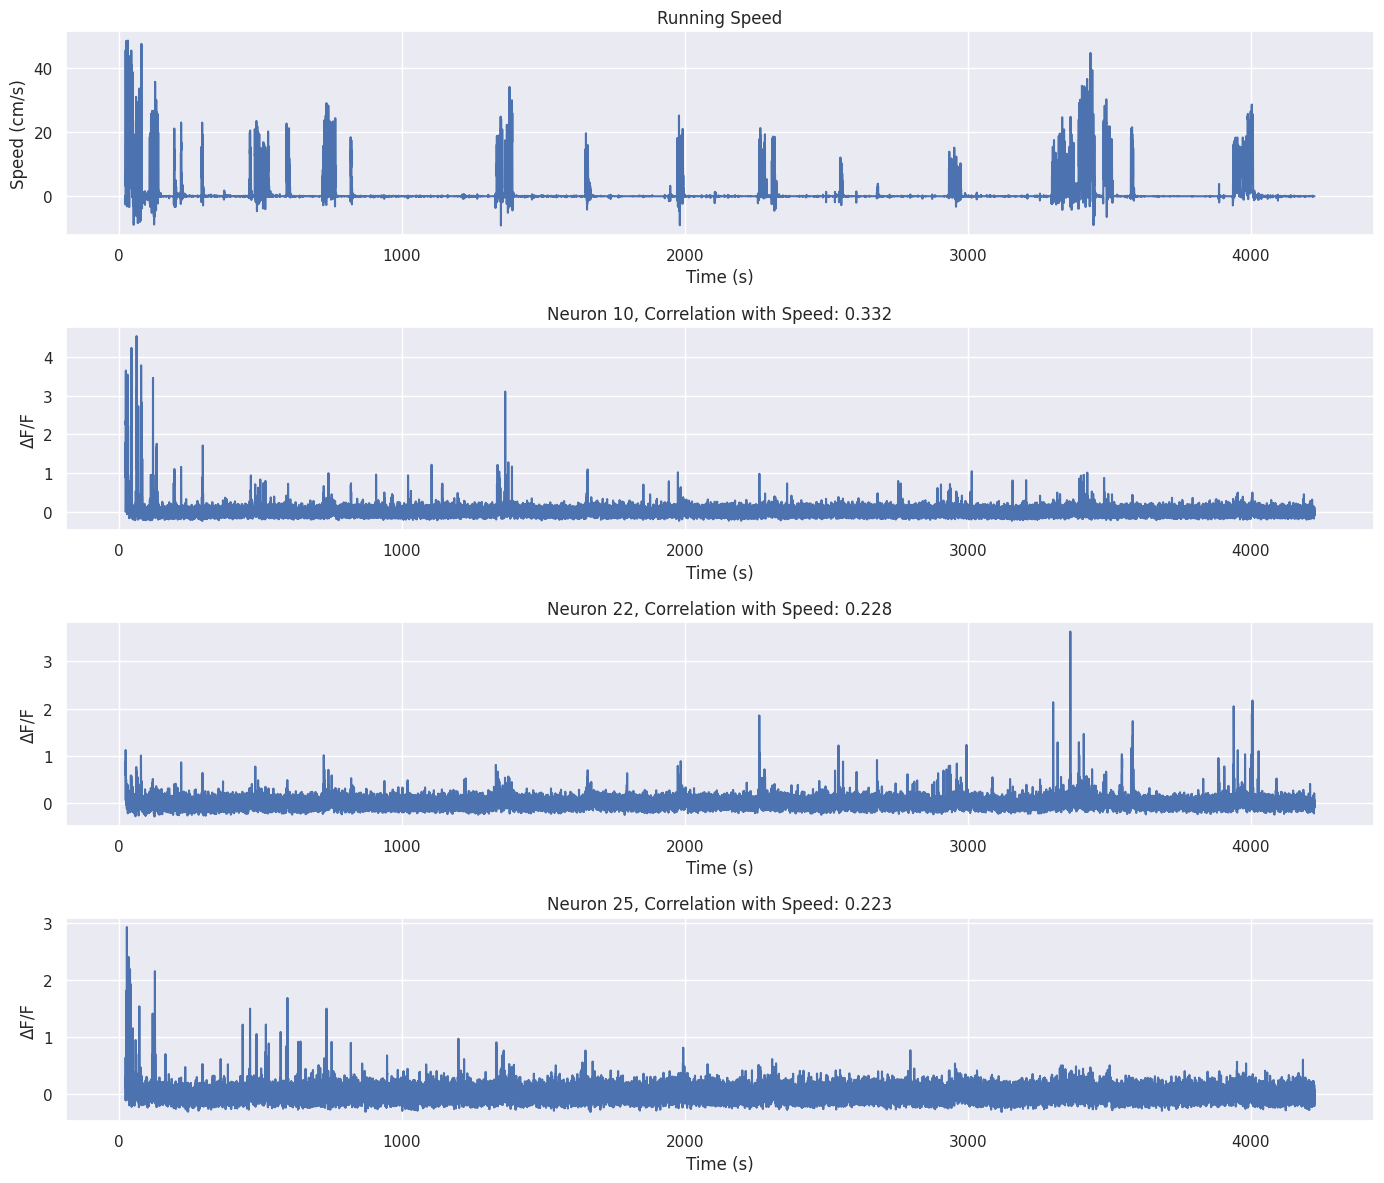

In [11]:
# Get the running speed data
running_module = nwb.processing["running"]
speed = running_module.data_interfaces["speed"]
speed_data = speed.data[:]
speed_times = speed.timestamps[:]

# Resample speed data to match neural data timestamps for correlation
# First, find overlapping time range
min_time = max(timestamps[0], speed_times[0])
max_time = min(timestamps[-1], speed_times[-1])

# Find indices within this range for both datasets
neural_inds = (timestamps >= min_time) & (timestamps <= max_time)
speed_inds = (speed_times >= min_time) & (speed_times <= max_time)

# Interpolate speed to match neural timestamps
from scipy.interpolate import interp1d
speed_interp = interp1d(speed_times[speed_inds], speed_data[speed_inds], 
                       bounds_error=False, fill_value='extrapolate')
matched_speed = speed_interp(timestamps[neural_inds])

# Calculate correlation between running speed and neural activity for each cell
correlations = []
for i in range(min(50, num_cells)):  # First 50 cells for efficiency
    dff_cell = dff_traces.data[neural_inds, i]
    corr = np.corrcoef(matched_speed, dff_cell)[0, 1]
    correlations.append((i, corr))

# Sort cells by correlation strength
correlations.sort(key=lambda x: abs(x[1]), reverse=True)

# Plot speed and neural activity for the top 3 correlated cells
plt.figure(figsize=(14, 12))

# First, plot the running speed
plt.subplot(4, 1, 1)
plt.plot(timestamps[neural_inds], matched_speed)
plt.title('Running Speed')
plt.ylabel('Speed (cm/s)')
plt.xlabel('Time (s)')

# Plot the neurons most correlated with running
for i, (cell_idx, corr) in enumerate(correlations[:3]):
    plt.subplot(4, 1, i+2)
    plt.plot(timestamps[neural_inds], dff_traces.data[neural_inds, cell_idx])
    plt.title(f'Neuron {cell_idx}, Correlation with Speed: {corr:.3f}')
    plt.ylabel('ΔF/F')
    plt.xlabel('Time (s)')

plt.tight_layout()

## Visualizing Cell Masks

Let's visualize the cell masks (ROIs) to better understand the spatial structure of the neurons.

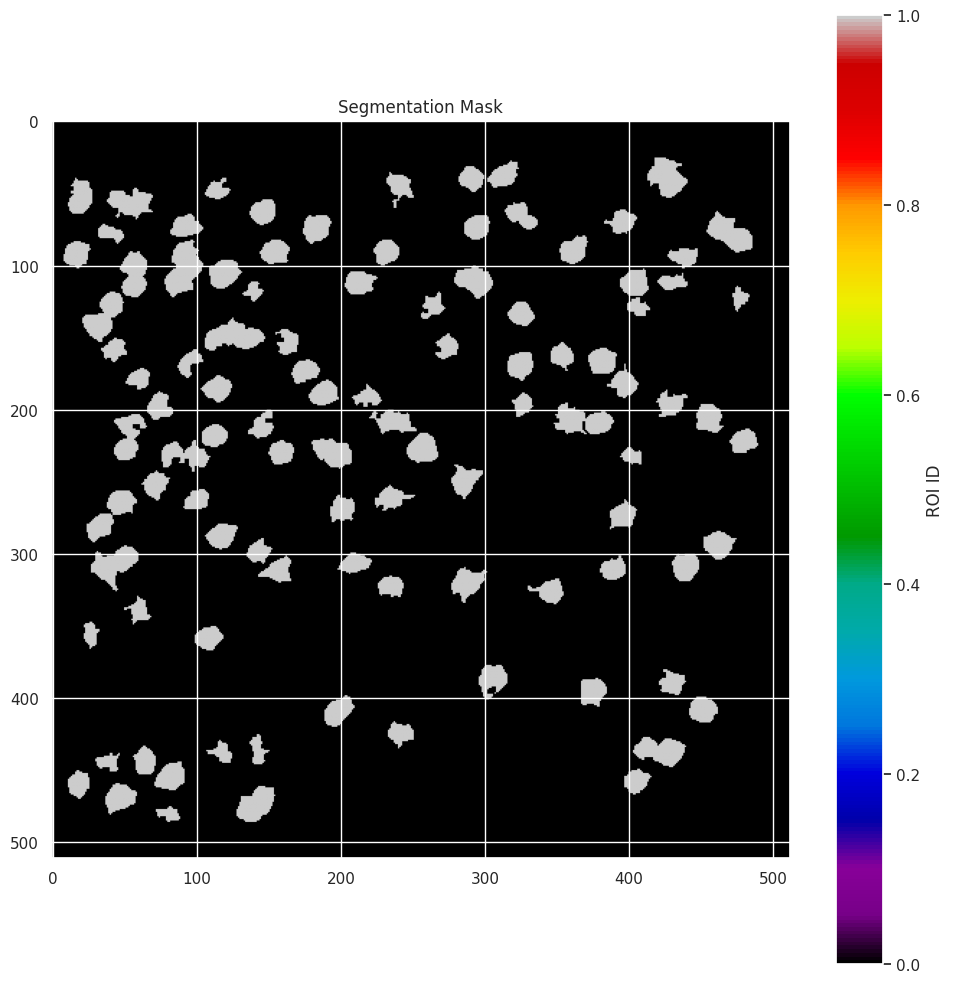

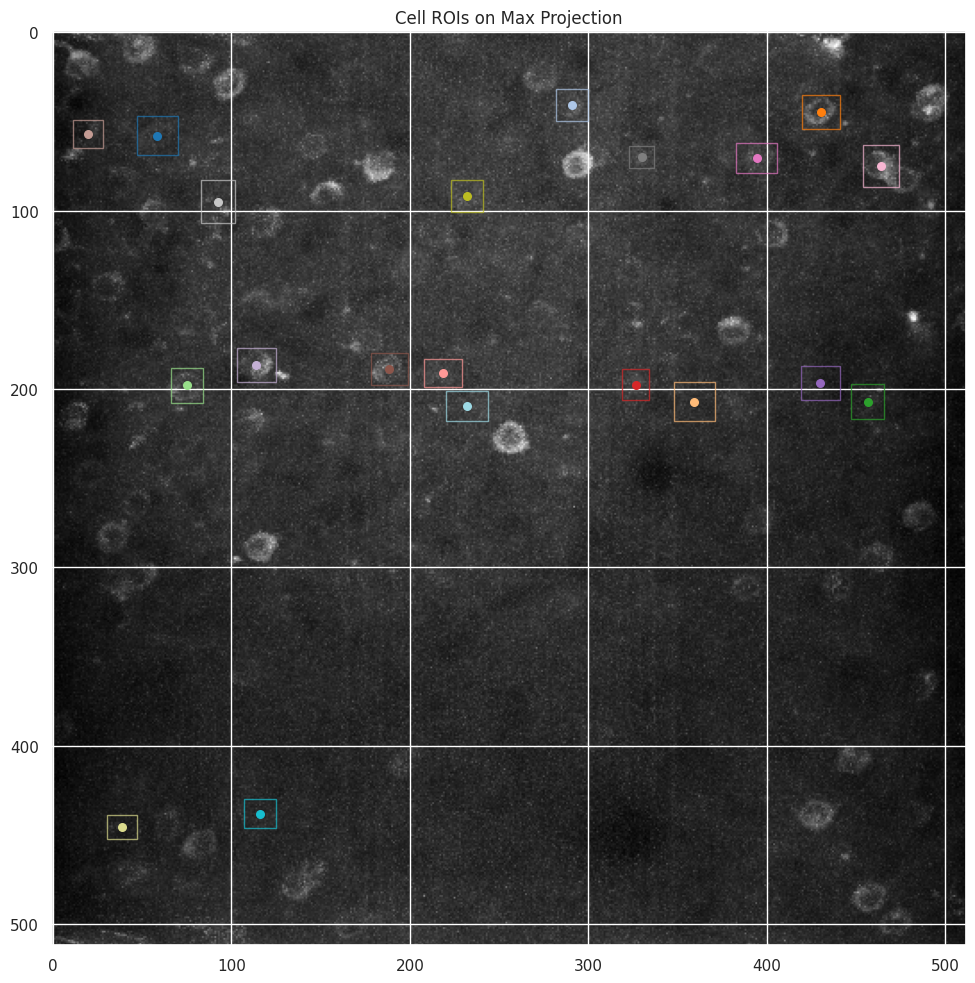

In [12]:
# Get the segmentation mask
segmentation_mask = np.array(images.images['segmentation_mask_image'])

# Plot the segmentation mask
plt.figure(figsize=(10, 10))
plt.imshow(segmentation_mask, cmap='nipy_spectral')
plt.colorbar(label='ROI ID')
plt.title('Segmentation Mask')
plt.tight_layout()

# Try to visualize individual cell ROIs on top of the max projection
plt.figure(figsize=(12, 10))
plt.imshow(max_proj, cmap='gray')

# Get cell masks and overlay them with transparency
n_cells_to_show = min(20, len(cell_data))  # Show only a few cells for clarity

# Define a colormap for cell visualization
colors = plt.cm.tab20(np.linspace(0, 1, n_cells_to_show))

for i in range(n_cells_to_show):
    mask = np.array(plane_seg['image_mask'][i])
    
    # Get coordinates for this mask
    x, y = cell_data.iloc[i]['x'], cell_data.iloc[i]['y']
    w, h = cell_data.iloc[i]['width'], cell_data.iloc[i]['height']
    
    # Overlay mask
    plt.scatter(x + w/2, y + h/2, color=colors[i], s=30, label=f'Cell {i}')
    
    # Draw rectangle around ROI
    rect = plt.Rectangle((x, y), w, h, linewidth=1, edgecolor=colors[i], 
                         facecolor='none', alpha=0.7)
    plt.gca().add_patch(rect)

plt.title('Cell ROIs on Max Projection')
plt.tight_layout()

## Link to Neurosift for Interactive Exploration

For interactive exploration of this NWB file, you can use the Neurosift web application by clicking the link below:

[View this NWB file in Neurosift](https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/27dd7936-b3e7-45af-aca0-dc98b5954d19/download/&dandisetId=000617&dandisetVersion=0.250312.0130)

Neurosift provides an interactive interface for exploring NWB files, including visualizing neural activity, stimulus presentations, and more.

## Summary and Future Directions

In this notebook, we've explored a dataset from the Allen Institute Openscope Sequence Learning Project. We've:

1. Loaded and examined the structure of the NWB file
2. Visualized calcium imaging data from neurons in visual cortex
3. Analyzed neural responses to different movie stimuli
4. Explored the spatial organization of neurons
5. Investigated the relationship between running speed and neural activity

### Key Findings

- We observed that neurons have distinct preferences for the different movie stimuli
- Many neurons showed a preference for Movie A
- We identified some neurons whose activity correlated with the animal's running speed
- The spatial organization of the neurons showed clustering in anatomical regions

### Future Directions

Future analyses could include:

1. **Sequence learning effects**: Compare neural responses before and after sequence training to identify changes in response patterns
2. **Multi-area comparison**: Compare responses across different visual areas (V1, LM, AM, PM)
3. **Layer-specific analysis**: Compare responses between layer 2/3 and layer 4 neurons
4. **Population decoding**: Train decoders to predict stimulus identity from population activity
5. **Predictive coding**: Analyze how neurons respond to expected vs. unexpected stimuli in the sequence
6. **Temporal dynamics**: Perform time-frequency analysis to identify oscillatory patterns in the data

By leveraging this rich dataset, researchers can gain insights into how the brain learns and predicts sequences of visual inputs.